# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Submission

With this project, I submit the following files and folders:

1. README.md: this readme file, generated from main.ipynb
2. main.ipynb: jupyter notebook containing the documentation and the main part of the pipeline
3. 



## Warmup
---
Before I start considering the rubric points, I add some of the exercises from the course.

### Exploring Colorspaces

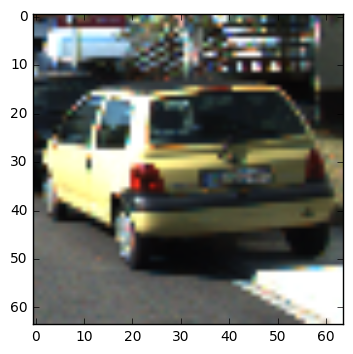

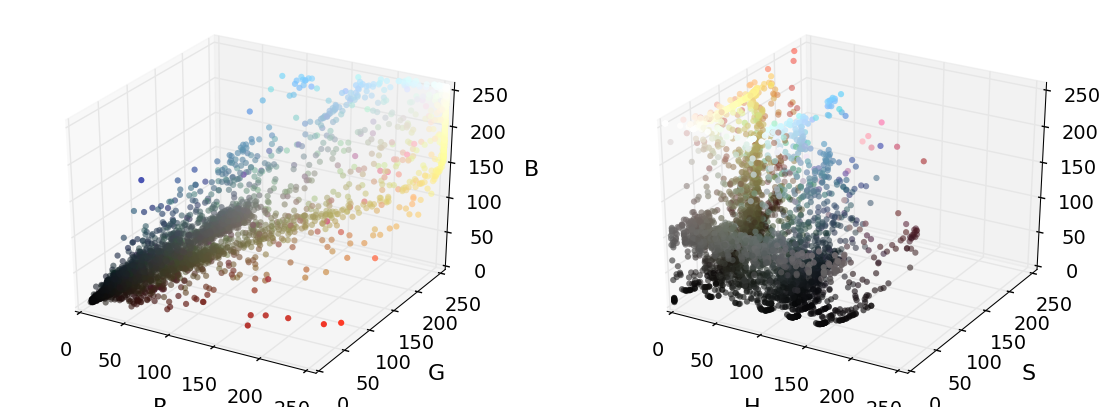

In [1]:
# this code is mainly from the lecture.

from helpers import *
#from lecture.plot3d import plot3d
from lib import plot3d
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

# Read a color image
img = cv2.imread("./lecture/14_color_spaces/25.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plt.figure(figsize=(14,4))
plt.imshow(bgr_rgb(img))

fig=plt.figure(figsize=(14,5))

ax=fig.add_subplot(1, 2, 1, projection='3d')
plot3d(ax, img_small_RGB, img_small_rgb)

ax=fig.add_subplot(1, 2, 2, projection='3d')
plot3d(ax, img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()


In HSV space, the yellow dots (the car) are (more or less) in a plane. Common to most cars: red lights in the back, black wheels. Black is not a color, so H channel does not help here...

### Combine and Normalize Features

number of samples in cars data set:  8792
number of samples in not-cars data set:  8968
reduction of samples in cars and not-cars data set to:  500
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168


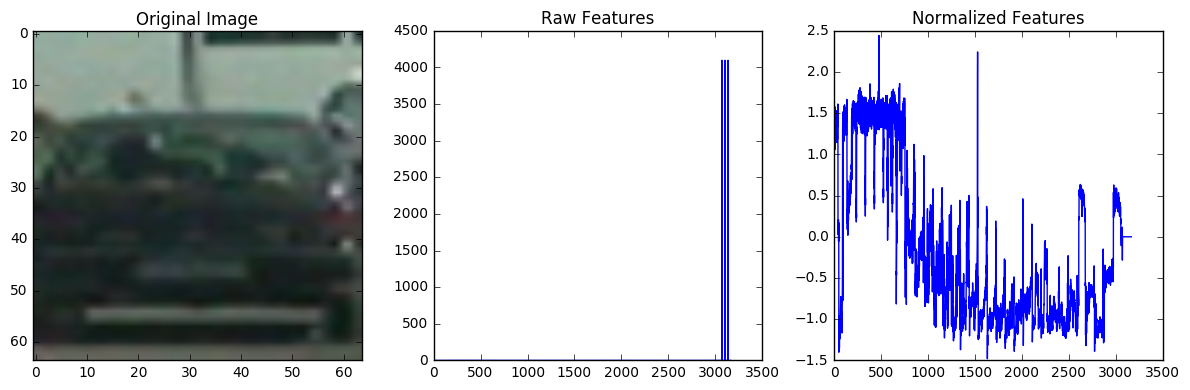

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from lib import *

cars=[]
for d in glob.glob('data/vehicles/*'):
    cars.extend(glob.glob(d+'/*.png'))

print("number of samples in cars data set: ", len(cars))
    
notcars = []
for d in glob.glob('data/non-vehicles/*'):
    notcars.extend(glob.glob(d+'/*.png'))
    
print("number of samples in not-cars data set: ", len(notcars))

nreduction=8792
nreduction=500
cars_red=cars[0:nreduction] # reduce number of samples for testing
notcars_red=notcars[0:nreduction] # reduce number of samples for testing
print("reduction of samples in cars and not-cars data set to: ", nreduction)

spatial=32
histbin=32
print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')

car_features = extract_features(cars_red, color_space='RGB', spatial_size=(spatial, spatial),
                               hist_bins=histbin, hog_feat=False)
notcar_features = extract_features(notcars_red, color_space='RGB', spatial_size=(spatial, spatial),
                               hist_bins=histbin, hog_feat=False)

print('Feature vector length:', len(notcar_features[0]))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars_red))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars_red[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Train a Classifier
Define a labels vector $y$ for cars (1) and non-car objects (0):

In [3]:
import numpy as np
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

Now stack the features vectors together and apply a normalization:

In [4]:
from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

Split feature vectors and labels into training and test set using `train_test_split` from `sklearn`. Hint: the package name depends on the version on `sklearn`, see comment.

In [5]:
# sklearn <0.18:
#from sklearn.cross_validation import train_test_split
# scikit-learn >= 0.18:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

<span style="color:red">__Note for myself as a reminder:__</span> videos are sequences of images where the target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set.

Now let's train a classifier:

In [6]:
from sklearn.svm import LinearSVC
import time
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


1.01 Seconds to train SVC...


Accuracy & Predictions:

In [7]:
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.925
My SVC predicts:  [ 0.  1.  0.  1.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  1.  0.  1.  0.  1.]
0.00121 Seconds to predict 10 labels with SVC


### HOG Classifier
HOG = histogram of oriented gradients


In [8]:

### TODO: Tweak these parameters and see how the results change.
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


t=time.time()

car_features = extract_features(cars_red, color_space='HLS', 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)
notcar_features = extract_features(notcars_red, color_space='HLS', 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=False, 
                        hist_feat=False, hog_feat=True)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

3.26 Seconds to extract HOG features...
Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10584
0.21 Seconds to train SVC...
Test Accuracy of SVC =  0.99
My SVC predicts:  [ 0.  1.  1.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  1.  1.  0.]
0.00166 Seconds to predict 10 labels with SVC


### Search and Classify

In [9]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 18  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (24, 24) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off

nreduction=8792
#nreduction=1000
cars_red=cars[0:nreduction] # reduce number of samples for testing
notcars_red=notcars[0:nreduction] # reduce number of samples for testing
print("reduction of samples in cars and not-cars data set to: ", nreduction)

car_features = extract_features(cars_red, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_red, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



reduction of samples in cars and not-cars data set to:  8792
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9878


Training the SVC with 8792 cars and not-cars images takes about 3.99s on my machine. Total time ~2minutes.

Now read in an image and search for cars...

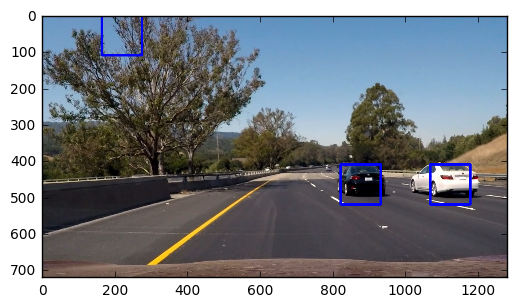

In [10]:
y_start_stop = [None, None] # Min and max in y to search in slide_window()

image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(110, 110), xy_overlap=(0.25, 0.25))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)



Obviously, it helps very much to increase the number of images for training the SVC. Also, the window size for searching seems to be crucial and must be adapted to the distance of camera->car.

I played with different color spaces, and first, HLS turned out to be best. I assume this is due to the separation into color, brightness and saturation, where saturation gives good gradients and color helps identifying the color of cars. After more experiments with the test images, I settled with YCrCb, which gave the overall best results wrt. correct detections and false detections.

Most successful parameters so far:

    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off


### HOG Sub-Sampling Window Search

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, draw_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


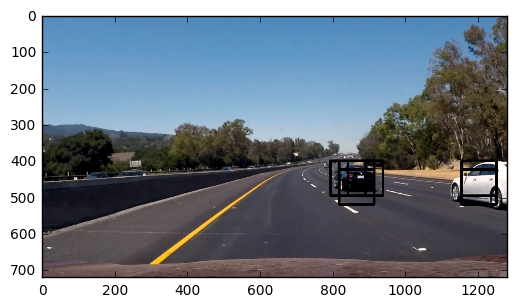

In [36]:
ystart = 400
ystop = 656
scale = 1.5

#image = mpimg.imread('test_images/test6.jpg')
#draw_img = np.copy(image)
#img = image.astype(np.float32)/255

image = mpimg.imread('project_video_frames/046.png')
draw_img = np.copy(image)
img = image

out_img = find_cars(img, draw_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
---
Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

## Writeup / README
---

- Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!


## Histogram of Oriented Gradients (HOG)
---

### Feature Detection

- Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in the first code cell of the IPython notebook (or in lines # through # of the file called `some_file.py`).  

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

### Parameter Selection

- Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

- Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...


## Sliding Window Search
---

### Implementation

- Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

### Classifier Optimization

- Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]



## Video Implementation
---

### Pipeline

- Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video_out.mp4)


- Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]






### Discussion
---

- Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

